In [1]:
# no repeat in train data and loss dropout
import numpy as np
import os
import csv
import re
import sys
import math
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from sklearn.utils import shuffle

import random

def generate_array(mode="train"):
    #global current_timestep
    while True:
        in_folder = os.path.join("/home","englab5510","PycharmProjects","mmWave1","LSTM_notebooks", "lstm_data")
        reorder = 0

        if(mode=="train"):
            current_timestep = random.randint(0, 39)
            if current_timestep >=31:
                reorder = 1
            else:
                reorder = 0

        elif(mode=="valid"):
            current_timestep = random.randint(40, 45)
        
        elif(mode=="test"):
            current_timestep = random.randint(45, 49)
      
        x = np.load(os.path.join(in_folder, "in_step{}.npy".format(current_timestep)))
        y = np.load(os.path.join(in_folder, "out_step{}.npy".format(current_timestep)))

        if reorder:
            max_num = 40
            repeat_last = 10 - (max_num - current_timestep)

            X = x[:,0:(10-repeat_last),:]
            Y = y[:,0:(10-repeat_last),:]
            X_new = np.zeros((X.shape[0], 10, X.shape[2]))
            Y_new = np.zeros((Y.shape[0], 10, Y.shape[2]))

            for k in range(0, X.shape[0]):
                for i in range(0, X_new.shape[1]):
                    if i < X.shape[1]:
                        X_new[k,i,:] = X[k,i,:]
                        Y_new[k,i,:] = Y[k,i,:]
                    else:
                        X_new[k,i,:] = X_new[k,i-1,:]
                        Y_new[k,i,:] = Y_new[k,i-1,:]
            X = X_new
            Y = Y_new

            X, Y = shuffle(x, y)

            yield (X,Y)

X_valid = np.load(os.path.join("/home","englab5510","PycharmProjects","mmWave1","LSTM_notebooks", "lstm_data","in_step40.npy"))
Y_valid = np.load(os.path.join("/home","englab5510","PycharmProjects","mmWave1","LSTM_notebooks", "lstm_data", "out_step40.npy"))
X_valid = X_valid[:,0:5]
Y_valid = Y_valid[:,0:5]
X_test = np.load(os.path.join("/home","englab5510","PycharmProjects","mmWave1","LSTM_notebooks", "lstm_data", "in_step45.npy"))
Y_test = np.load(os.path.join("/home","englab5510","PycharmProjects","mmWave1","LSTM_notebooks", "lstm_data", "out_step45.npy"))
X_test = X_test[:,0:5]
Y_test = Y_test[:,0:5]

print(X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape)

(863, 5, 23000) (863, 5, 61) (863, 5, 23000) (863, 5, 61)


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, TimeDistributed, Activation, Dense, Bidirectional
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from livelossplot import PlotLossesKeras

model = Sequential()
model.add(Bidirectional(LSTM(40, return_sequences=True), input_shape=(None,23000)))
model.add(Bidirectional(LSTM(20, return_sequences=True)))
model.add(TimeDistributed(Dense(128, activation="relu")))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Dense(61, activation="softmax")))
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              #optimizer=tf.keras.optimizers.Adadelta(lr=1.0),
              optimizer=tf.keras.optimizers.SGD(lr=0.0052),
              #optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

checkpoint_path = "/home/englab5510/PycharmProjects/mmWave1/reinforcement_data/trial3/lstm_models/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',mode='min', verbose=1, save_best_only=True)
csv_logger = CSVLogger('/home/englab5510/PycharmProjects/mmWave1/reinforcement_data/trial3/cnn_models/training.log', append=True, separator=',')

#model.load_weights('/content/drive/My Drive/Colab Notebooks/lstm_models/cp-0105.ckpt')

history = model.fit_generator(
    generate_array(mode="train"),
    steps_per_epoch = 863,
    validation_data = (X_valid, Y_valid),
    validation_steps = 863,
    epochs = 300,
    verbose=1,
    shuffle=True,
    initial_epoch =0,
    callbacks=[es, cp_callback, csv_logger, PlotLossesKeras()])
    #validation_data=(X_test, y_test)

<Figure size 1200x800 with 2 Axes>

Log-loss (cost function):
training   (min:    0.010, max:    2.111, cur:    0.010)
validation (min:    0.021, max:    1.763, cur:    0.021)

Accuracy:
training   (min:    0.570, max:    0.998, cur:    0.998)
validation (min:    0.575, max:    0.995, cur:    0.995)
863/863 [==============================] - 936s 1s/step - loss: 0.0096 - acc: 0.9984 - val_loss: 0.0210 - val_acc: 0.9949


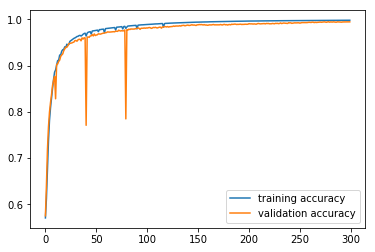

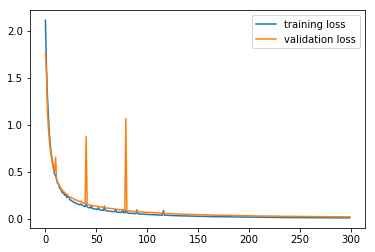

In [3]:
import matplotlib.pyplot as plt

val_acc = history.history['val_acc']
acc = history.history['acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_num = np.arange(0, len(val_acc), dtype=int)
plot1, = plt.plot(epoch_num, acc)
plot2, = plt.plot(epoch_num, val_acc)
plt.legend([plot1, plot2],['training accuracy', 'validation accuracy'])
plt.show()
plot1, = plt.plot(epoch_num, loss)
plot2, = plt.plot(epoch_num, val_loss)
plt.legend([plot1, plot2],['training loss', 'validation loss'])


In [4]:
import requests

def telegram(message):

    bot_token = '923260274:AAHyCqG6jpPI_xo0x2wJvhGVA_oeUnMf41Y'
    bot_chatID = '763781536'
    send = 'https://api.telegram.org/bot' + bot_token + '/sendMessage?chat_id=' + bot_chatID + '&parse_mode=Markdown&text=' + message
    try:
        response = requests.get(send)
        response.raise_for_status()
    except requests.exceptions.RequestException as err:
        print ("OOps: Something Else",err)
    except requests.exceptions.HTTPError as errh:
        print ("Http Error:",errh)
    except requests.exceptions.ConnectionError as errc:
        print ("Error Connecting:",errc)
    except requests.exceptions.Timeout as errt:
        print ("Timeout Error:",errt)  
    return response.json()

telegram("LSTM bidirectional done!")

train_result = model.evaluate_generator(
    generate_array(mode="train"), 
    steps = 863,
    verbose=0)
print('training loss:',train_result[0])
print('training accuracy:', train_result[1])

valid_result = model.evaluate(X_valid, Y_valid, verbose=0)
print('validation loss:',valid_result[0])
print('validation accuracy:', valid_result[1])

test_result = model.evaluate(X_test, Y_test, verbose=0)
print('testing loss:',test_result[0])
print('testing accuracy:', test_result[1])

message = "LSTM englab5510\n" + "test_loss :" + str(test_result[0]) + "\n" + "test_acc :" + str(test_result[1])  + "\n" + "valid_loss :" + str(valid_result[0]) + "\n" + "valid_acc :" + str(valid_result[1]) + "\n" + "train_loss :" + str(train_result[0]) + "\n" + "train_acc :" + str(train_result[1]) 
telegram(message)

training loss: 0.0034454935815763743
training accuracy: 0.999591294749449
validation loss: 0.020967099008388897
validation accuracy: 0.9949014990796634
testing loss: 0.5637243234683023
testing accuracy: 0.9001158752143038


{'ok': True,
 'result': {'message_id': 132,
  'from': {'id': 923260274,
   'is_bot': True,
   'first_name': 'NeeNo',
   'username': 'NeeNoKibot'},
  'chat': {'id': 763781536,
   'first_name': 'Shalom',
   'username': 'NeeNoKi',
   'type': 'private'},
  'date': 1569781109,
  'text': 'LSTM englab5510\ntestloss :0.5637243234683023\ntestacc :0.9001158752143038\nvalidloss :0.020967099008388897\nvalidacc :0.9949014990796634\ntrainloss :0.0034454935815763743\ntrainacc :0.999591294749449',
  'entities': [{'offset': 20, 'length': 29, 'type': 'italic'},
   {'offset': 78, 'length': 32, 'type': 'italic'},
   {'offset': 139, 'length': 33, 'type': 'italic'}]}}

In [5]:
val_acc = history.history['val_acc']
acc = history.history['acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

np.savez('/home/englab5510/PycharmProjects/mmWave1/reinforcement_data/trial3/cnn_models/val_acc.npz', acc=acc, loss=loss, val_acc=val_acc, val_loss=val_loss)